In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython import display
from IPython.display import HTML
import cv2
import os
import datetime
import argparse

print('Libraries imported')

Libraries imported


In [2]:
# practical function to guarantee repeatability of the experiments
def guarantee_repeatability(seed):
    tf.random.set_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)
    
seed = 0

# Performing random moves

In [3]:
# create environment and return some info
def make_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env
    
env_name = 'MountainCarContinuous-v0'
print(env_name)
env = make_environment(env_name)

MountainCarContinuous-v0
Action Space: Box(-1.0, 1.0, (1,), float32)
Observation Space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0


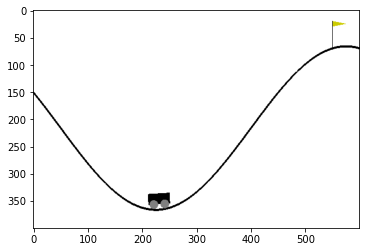

In [4]:
# repeatability
guarantee_repeatability(seed)

env.reset()
# start storing every single frame...
img = plt.imshow(env.render(mode='rgb_array'))
savepath = 'videos/car_'+str(datetime.datetime.now())+'.png'
plt.savefig(savepath)

num_steps = 100

for t in range(num_steps):
    # ... by updating at every step 
    img.set_data(env.render(mode='rgb_array'))
    savepath = 'videos/car_'+str(datetime.datetime.now())+'.png'
    plt.savefig(savepath)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # default mode of OpenAI gym
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    #if done:
    #    print("Episode finished after {} timesteps".format(t+1))
    #    break
    
env.close()

In [5]:
# collecting every frame in an array
img_array = []
for filename in sorted(glob.glob('videos/car_*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    os.remove(filename)
    
video_path = 'videos/car_init.avi'
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 7.5, size)

# re-creating frames as a video in 'avi' format
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

print('Video saved at ' + video_path)

Video saved at videos/car_init.avi


# Soft Actor-Critic

### Training

In [3]:
# importing our packages
from sac.sac import SoftActorCritic
from sac.replay_buffer import ReplayBuffer

In [4]:
# create environment and return some info
def make_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env
    
env_name = 'MountainCarContinuous-v0'
print(env_name)
env = make_environment(env_name)

MountainCarContinuous-v0
Action Space: Box(-1.0, 1.0, (1,), float32)
Observation Space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0


In [5]:
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
#print(state_dim, action_dim)

# repeatability
guarantee_repeatability(seed)

size = 1000000
buf = ReplayBuffer(state_dim, num_actions, size)

sac = SoftActorCritic(state_dim, num_actions)

In [6]:
episodes = 50
total_steps = 0
total_episodes = 0
max_episode_steps = env.spec.max_episode_steps # in MCC-v0 it is 999
# number of actions to make exploration
acts = 4

# arrays to store results over time
episode_lengths = []
episode_rewards = []
actor_losses = []
critic1_losses = []
critic2_losses = []

# flag to set exploration:
# if True -> explore, otherwise -> learn
flag = True
# buf size to start learning
start_size = 10000
batch_size = 128

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    
    for s in range(max_episode_steps):
        action = sac.take_action(state)
        # stochastic exploration
        if flag == True and np.random.uniform() < 0.5:
            for a in range(acts):
                env.step(action)
        
        # update everything after a step
        next_state, reward, done, _ = env.step(action.numpy())
        episode_reward += reward
        total_steps += 1
        buf.save(state, action, reward, next_state, done)
        if (buf.size > start_size):
            if flag == True:
                print('Ready for the training')
                flag = False
                # now I'm learning
            
            # sampling
            states, next_states, actions, rewards, dones = buf.sample_batch(size=batch_size)
            
            # do the sac stuff
            critic1_loss, critic2_loss, actor_loss = sac.train(states, actions, next_states, rewards, dones, batch_size)
            actor_losses.append(actor_loss)
            critic1_losses.append(critic1_loss)
            critic2_losses.append(critic2_loss)
            
        state = next_state
        
        # collect info and start a new episode
        if done:
            episode_lengths.append(s)
            episode_rewards.append(episode_reward)
            total_episodes += 1
            if total_episodes % 10 == 0:
                print('Episode %d, reward %f, steps %d' %(total_episodes, episode_reward, s))
            sac.actor.save_weights('models/car_model')
            break
            
env.close()

Episode 10, reward -12.791583, steps 318
Episode 20, reward 95.494247, steps 117
Episode 30, reward -13.008412, steps 333
Ready for the training
Episode 40, reward 65.861354, steps 954
Episode 50, reward 94.784766, steps 77


### Plotting results

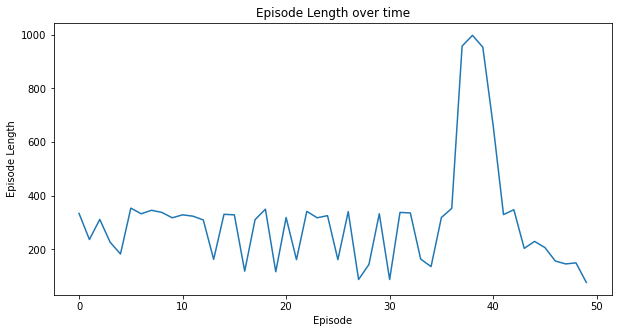

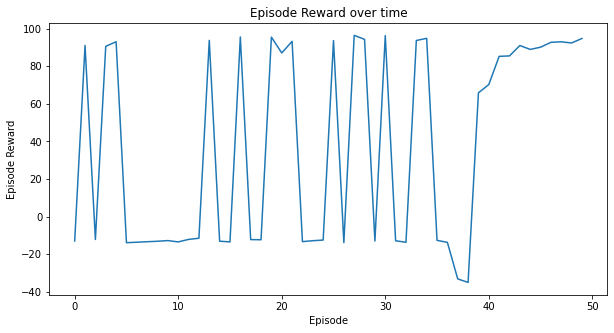

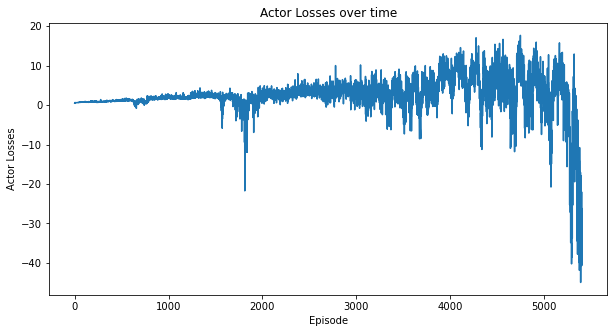

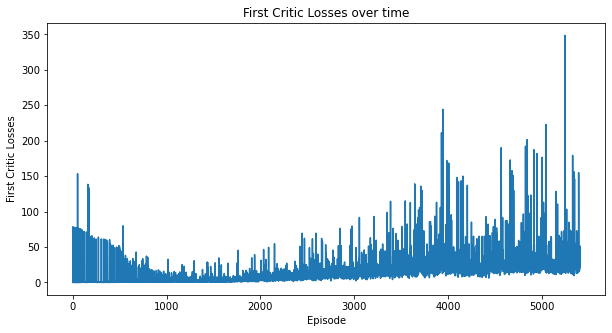

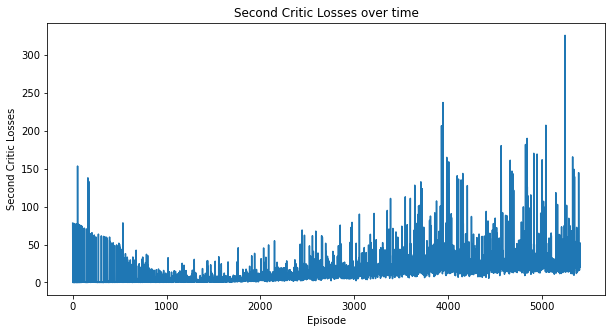

In [7]:
def plot_result(to_plot, xlabel, ylabel, title, savepath):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(to_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(savepath)
    plt.show()

# plotting episode lengths
plot_result(episode_lengths, 'Episode', 'Episode Length',
            'Episode Length over time', 'results/car_episode_length_over_time')

# plotting episode rewards
plot_result(episode_rewards, 'Episode',
            'Episode Reward', 'Episode Reward over time',
            'results/car_episode_reward_over_time')

# plot losses
plot_result(actor_losses, 'Episode',
            'Actor Losses', 'Actor Losses over time',
            'results/car_actor_losses_over_time')
plot_result(critic1_losses, 'Episode',
            'First Critic Losses', 'First Critic Losses over time',
            'results/car_critic1_losses_over_time')
plot_result(critic2_losses, 'Episode',
            'Second Critic Losses', 'Second Critic Losses over time',
            'results/car_critic2_losses_over_time')


### Testing

In [11]:
from sac.sac import SoftActorCritic

Episode finished after 109 timesteps
Cumulative reward: 94.187089


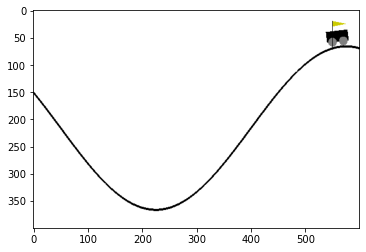

In [9]:
env_name = 'MountainCarContinuous-v0'
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
sac = SoftActorCritic(state_dim, num_actions)

# repeatability
guarantee_repeatability(seed)

sac.actor.load_weights('models/car_model')

max_episode_length = 200
state = env.reset()
# start storing every single frame...
img = plt.imshow(env.render(mode='rgb_array'))
savepath = 'videos/car_'+str(datetime.datetime.now())+'.png'
plt.savefig(savepath)
done = 0
cumulative_reward = 0
for _ in range(max_episode_length):
    action = sac.take_action(state)
    next_state, reward, done, info = env.step(action)
    cumulative_reward += reward
    img.set_data(env.render(mode='rgb_array'))
    savepath = 'videos/car_'+str(datetime.datetime.now())+'.png'
    plt.savefig(savepath)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        print("Episode finished after {} timesteps".format(_+1))
        break
    
    state = next_state
    
print('Cumulative reward: %f' %(cumulative_reward))
env.close()

In [10]:
# collecting every frame in an array
img_array = []
for filename in sorted(glob.glob('videos/car_*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    os.remove(filename)
    
video_path = 'videos/car_sac.avi'
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 16, size)

# re-creating frames as a video in 'avi' format
for i in range(len(img_array)):
    out.write(img_array[i])
    
out.release()

print('Video saved at ' + video_path)

Video saved at videos/car_sac.avi
